In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import kagglehub
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dheerajperumandla/drowsiness-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'drowsiness-dataset' dataset.
Path to dataset files: /kaggle/input/drowsiness-dataset


## Labels

In [ ]:
data_path = Path('/root/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train')
labels = os.listdir(path)
print(labels)

['train']


## Visualize A random image

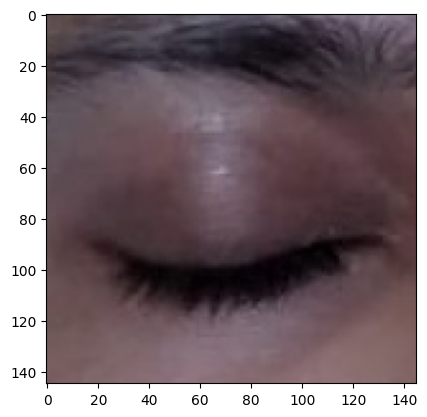

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(data_path.joinpath('Closed').joinpath('_0.jpg')))

## Image array

In [ ]:
a = plt.imread(data_path.joinpath('yawn').joinpath('10.jpg'))

## Image shape

In [ ]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array)


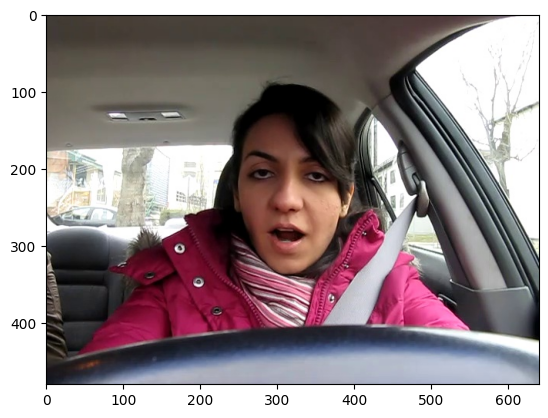

In [ ]:
plt.imshow(plt.imread(data_path.joinpath('yawn').joinpath('10.jpg')))

In [ ]:
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
face_cascade_path = os.path.join(cv2_base_dir, "data/haarcascade_frontalface_default.xml")

print("Ruta del HaarCascade:", face_cascade_path)

Ruta del HaarCascade: /usr/local/lib/python3.12/dist-packages/cv2/data/haarcascade_frontalface_default.xml


## Take only face(For yawn and not_yawn)

In [ ]:
def face_for_yawn(direc, face_cas_path):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

In [ ]:
yawn_no_yawn = face_for_yawn(data_path, face_cascade_path)

0
1


## For Closed and Open eye

In [ ]:
def get_data(dir_path):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data(data_path)

2
3


## Extend data and Convert array

In [ ]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn(data_path, face_cascade_path)
    data = get_data(data_path)
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

## New variable to store

In [ ]:
new_data = append_data()

0
1
2
3


In [ ]:
new_data

array([[array([[[  0, 255,   0],
                [  0, 255,   0],
                [  0, 255,   0],
                ...,
                [  0, 255,   0],
                [  0, 255,   0],
                [  0, 255,   0]],

               [[  0, 255,   0],
                [  0, 244,   1],
                [  1, 203,   6],
                ...,
                [ 15, 217,  19],
                [ 14, 216,  18],
                [  1, 252,   1]],

               [[  0, 255,   0],
                [  1, 203,   6],
                [  7,  16,  27],
                ...,
                [ 68,  81,  87],
                [ 65,  77,  83],
                [  4, 242,   6]],

               ...,

               [[  0, 255,   0],
                [  0, 200,   0],
                [  1,   0,   0],
                ...,
                [ 22,  38,  51],
                [ 33,  46,  58],
                [  3, 240,   4]],

               [[  0, 255,   0],
                [  0, 199,   0],
                [  1,   0,   

## Separate label and features

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [ ]:
y = np.array(y)

## Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [ ]:
len(X_test)

578

## Import some dependencies

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 143, 143, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 71, 71, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 69, 69, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 427s 10s/step - accuracy: 0.3724 - loss: 1.3171 - val_accuracy: 0.7388 - val_loss: 0.6283
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 413s 10s/step - accuracy: 0.7716 - loss: 0.5463 - val_accuracy: 0.8287 - val_loss: 0.4208
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 403s 9s/step - accuracy: 0.8178 - loss: 0.4177 - val_accuracy: 0.8581 - val_loss: 0.3562
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step - accuracy: 0.8420 - loss: 0.3718 - val_accuracy: 0.8910 - val_loss: 0.2843
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step - accuracy: 0.8727 - loss: 0.3050 - val_accuracy: 0.9066 - val_loss: 0.2716
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 404s 9s/step - accuracy: 0.8558 - loss: 0.3159 - val_accuracy: 0.9239 - val_loss: 0.2564
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 439s 10s/step - accuracy: 0.8826 - loss: 0.2841 - val_accuracy: 0.8737 - val_loss: 0.2850
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 400s 9s/step - accuracy: 0.8919 - loss: 0.2568 - val_accuracy: 0.878

## History

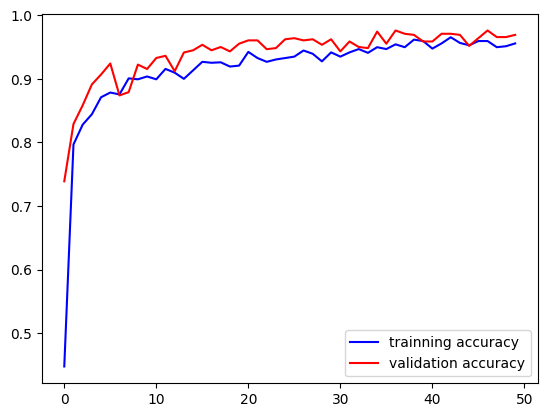

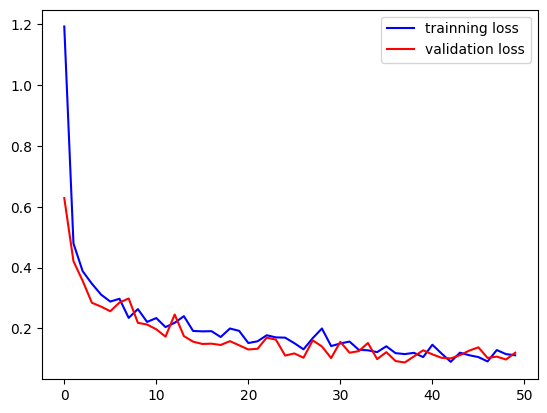

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [ ]:
model.save("drowiness_new7.h5")

In [ ]:
model.save("drowiness_new7.keras")

# Prediction

In [ ]:
predictions = model.predict(X_test)
prediction = np.argmax(predictions, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


# classification report

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.93      0.90      0.92        63
     no_yawn       0.89      0.96      0.92        74
      Closed       0.96      0.97      0.96       215
        Open       0.98      0.95      0.96       226

    accuracy                           0.95       578
   macro avg       0.94      0.95      0.94       578
weighted avg       0.95      0.95      0.95       578



# predicting function

In [ ]:
def prepare(filepath, face_cas_path=face_cascade_path):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    if img_array is None:
        print(f"Error: No se pudo cargar la imagen en {filepath}")
        return None
    img_array = img_array / 255.0
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
loaded_model = tf.keras.models.load_model("drowiness_new7.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_image = prepare("ruta/a/tu/imagen.jpg")
if test_image is not None:
    pred = loaded_model.predict(test_image)
    result = np.argmax(pred)
    print(f"Predicción: {labels_new[result]}")

Error: No se pudo cargar la imagen en ruta/a/tu/imagen.jpg


Imágenes disponibles en 'yawn':
['528.jpg', '42.jpg', '644.jpg', '508.jpg', '116.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicción: yawn


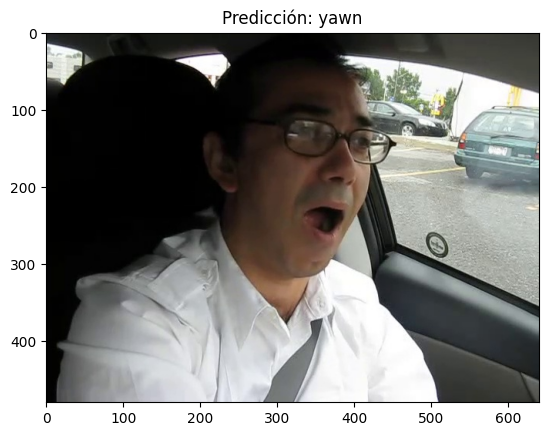

In [ ]:
# Ejemplo con una imagen del dataset
import os

# Ver qué imágenes tienes disponibles
print("Imágenes disponibles en 'yawn':")
print(os.listdir(data_path.joinpath('yawn'))[:5])  # Muestra las primeras 5

# Usar una imagen existente
test_image_path = str(data_path.joinpath('yawn', '116.jpg'))
test_image = prepare(test_image_path)

if test_image is not None:
    pred = loaded_model.predict(test_image)
    result = np.argmax(pred)
    print(f"Predicción: {labels_new[result]}")

    # Opcional: visualizar la imagen
    import matplotlib.pyplot as plt
    plt.imshow(plt.imread(test_image_path))
    plt.title(f"Predicción: {labels_new[result]}")
    plt.show()